<a href="https://colab.research.google.com/github/sameersundrani/CS230_FinalProject_Covid19Inaccuracies/blob/main/Final%20Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<center>$\textrm{Universidad Nacional de Colombia}$</center>
<center>$\textrm{Facultad de Ciencias}$</center>
<center>$\textrm{Redes Neuronales, Arquitecturas y Aplicaciones}$</center>

<h1><center>$\textrm{Final Assingment}$</center></h1>
<h2><center>$\textrm{A Deep Learning Approach to Population}$</h2>
<h2><center>$\textrm{Level COVID-19 Case Prediction in the US}$</h2>
<center>$\textrm{By Sameer Sundrani and Amy Zhang}$</center>

$\textrm{Jerson Felipe Guerrero Espitia}$

$\textrm{Maestría en Ciencias Económicas}$

# **1. INTRODUCTION** 
This notebook is built upon the project originally created by Sameer Sundrani and Amy This Zhang for the CS230 Class in Stanford University [A Deep Learning Approach to Population Level COVID-19 Case Prediction in the US](http://cs230.stanford.edu/projects_fall_2021/reports/102717926.pdf).

This work is aimed at analizing the incidence of movement behaviour of people on COVID propagation. Data collected from the US Department of Transportation Bureau of Transportation Statistics that tracks movements behavour of population segregated by state, convinated with  economic indicators from the U.S. Department of Agriculture
Economic Research Service, and COVID case data aggregated by the New York Times.

In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
#TO DO: IMPORT ALL FILES HERE
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_absolute_error #for linear regression evaluation
from sklearn import linear_model
from sklearn import preprocessing
#END TO DO
from google.colab import drive

2.12.0


In [2]:
drive.mount('/content/drive', force_remount=True)
FOLDERNAME = '/content/drive/MyDrive/Colab Notebooks/CS230_FINAL_PROJECT'


Mounted at /content/drive


In [3]:
travel_data_raw = pd.read_csv(FOLDERNAME + "/Trips_by_Distance.csv")
covid_counts_raw = pd.read_csv(FOLDERNAME + "/us-counties.csv")

# **2. DATA SET** 

Data used in this project were collected from the following resources:


*   Trips by Distance - 2.005.832 rows of information by county with the following columns: 
1. Date
2. State Postal Code
3. County Name
4. Number of Trips
5. Number of Trips <1. 
6. Number of Trips 1-3
7. Number of Trips 3-5
8. Number of Trips 5-10
9. Number of Trips 10-25
10. Number of Trips 25-50
11. Number of Trips 50-100
12. Number of Trips 100-250
13. Number of Trips 250-500
14. Number of Trips >=500
*   Unemployment and Poverty - 3195 rows of information.
*   Covid Cases per day per County




In [4]:
#travel_data_raw.head()
travel_counties = travel_data_raw.loc[travel_data_raw['Level'] == "County"]
travel_counties_final = travel_counties[['Date', 'State Postal Code', 'County Name', 'Number of Trips', 'Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5', 'Number of Trips 5-10', 'Number of Trips 10-25', 'Number of Trips 25-50', 'Number of Trips 50-100', 'Number of Trips 100-250', 'Number of Trips 250-500', 'Number of Trips >=500']]
travel_counties_final['County Name'] = travel_counties_final['County Name'].apply(lambda x: x.split(" ")[0])
travel_counties_final = travel_counties_final.rename(columns={"Date": "date", "State Postal Code": "state", "County Name": "county"})
travel_counties_final.head()

<ipython-input-4-d2c24e945073>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_counties_final['County Name'] = travel_counties_final['County Name'].apply(lambda x: x.split(" ")[0])


,date,state,county,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
52,2020/01/21,NY,Hamilton,18285.0,3025.0,2790.0,1196.0,4534.0,4854.0,1467.0,283.0,38.0,98.0,0.0
53,2020/01/21,NM,Doña,913920.0,218380.0,265268.0,141106.0,132456.0,91822.0,36900.0,20212.0,5245.0,1837.0,694.0
54,2020/01/21,AK,Bristol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,2020/01/21,VA,Louisa,147505.0,24957.0,29645.0,19679.0,18592.0,28460.0,19974.0,5247.0,785.0,117.0,49.0
56,2020/01/21,VA,Loudoun,1445859.0,351327.0,332129.0,160314.0,198232.0,268757.0,113140.0,13122.0,5814.0,1395.0,1629.0


In [5]:
covid_counts_final = covid_counts_raw[['date', 'county', 'state', 'cases']]
covid_counts_final['date'] = covid_counts_final['date'].apply(lambda x: x.replace('-', '/'))
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "Virgin Islands": "VI",
}
covid_counts_final['state'] = covid_counts_final['state'].apply(lambda x: us_state_to_abbrev[x])
covid_counts_final.head()

<ipython-input-5-9e1ffaf335ab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_counts_final['date'] = covid_counts_final['date'].apply(lambda x: x.replace('-', '/'))
<ipython-input-5-9e1ffaf335ab>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_counts_final['state'] = covid_counts_final['state'].apply(lambda x: us_state_to_abbrev[x])


,date,county,state,cases
0,2020/01/21,Snohomish,WA,1
1,2020/01/22,Snohomish,WA,1
2,2020/01/23,Snohomish,WA,1
3,2020/01/24,Cook,IL,1
4,2020/01/24,Snohomish,WA,1


In [6]:
final_data = pd.merge(covid_counts_final, travel_counties_final)
final_data.head()

,date,county,state,cases,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
0,2020/01/21,Snohomish,WA,1,2944078.0,762651.0,726576.0,308236.0,417195.0,540130.0,159563.0,20442.0,4391.0,1152.0,3742.0
1,2020/01/22,Snohomish,WA,1,3006800.0,784271.0,732019.0,311760.0,432308.0,551873.0,165546.0,21241.0,3654.0,1031.0,3097.0
2,2020/01/23,Snohomish,WA,1,2952207.0,782244.0,724152.0,305706.0,405046.0,535931.0,167202.0,22195.0,5095.0,1135.0,3501.0
3,2020/01/24,Cook,IL,1,21307310.0,6266951.0,5185299.0,2574174.0,3260629.0,2988478.0,774147.0,130659.0,86057.0,24356.0,16560.0
4,2020/01/24,Snohomish,WA,1,3167046.0,857787.0,779656.0,334594.0,448890.0,550137.0,160682.0,23484.0,6369.0,1343.0,4104.0


In [7]:
final_data.to_csv(FOLDERNAME+'/final_data.csv')

In [8]:
print("Number of Total Inputs: ", len(final_data))
# print("Confirmed (number should be the same): ",np.sum(final_data.groupby('county').size().to_list()))
print("Number of Total Counties: " ,len(final_data.groupby('county').size().to_list()))

Number of Total Inputs:  791981
Number of Total Counties:  1620


# **3. INITIAL MODELING**

In [9]:
final_data_old = pd.read_csv(FOLDERNAME+'/final_data.csv').iloc[0:, 1:]
final_data_old = final_data_old.dropna()
final_data_old

,date,county,state,cases,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
0,2020/01/21,Snohomish,WA,1,2944078.0,762651.0,726576.0,308236.0,417195.0,540130.0,159563.0,20442.0,4391.0,1152.0,3742.0
1,2020/01/22,Snohomish,WA,1,3006800.0,784271.0,732019.0,311760.0,432308.0,551873.0,165546.0,21241.0,3654.0,1031.0,3097.0
2,2020/01/23,Snohomish,WA,1,2952207.0,782244.0,724152.0,305706.0,405046.0,535931.0,167202.0,22195.0,5095.0,1135.0,3501.0
3,2020/01/24,Cook,IL,1,21307310.0,6266951.0,5185299.0,2574174.0,3260629.0,2988478.0,774147.0,130659.0,86057.0,24356.0,16560.0
4,2020/01/24,Snohomish,WA,1,3167046.0,857787.0,779656.0,334594.0,448890.0,550137.0,160682.0,23484.0,6369.0,1343.0,4104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791976,2020/12/31,Sweetwater,WY,2966,155442.0,42769.0,51380.0,17670.0,12644.0,17677.0,6073.0,3458.0,3316.0,425.0,30.0
791977,2020/12/31,Teton,WY,2138,98648.0,26662.0,21598.0,14716.0,15976.0,12885.0,4352.0,1549.0,572.0,141.0,197.0
791978,2020/12/31,Uinta,WY,1558,79852.0,19802.0,27118.0,10551.0,7357.0,6163.0,4209.0,3587.0,913.0,106.0,46.0
791979,2020/12/31,Washakie,WY,780,29819.0,13642.0,5794.0,3505.0,1639.0,1567.0,2062.0,1283.0,260.0,65.0,2.0


In [10]:
final_data_old.columns

Index(['date', 'county', 'state', 'cases', 'Number of Trips',
       'Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5',
       'Number of Trips 5-10', 'Number of Trips 10-25',
       'Number of Trips 25-50', 'Number of Trips 50-100',
       'Number of Trips 100-250', 'Number of Trips 250-500',
       'Number of Trips >=500'],
      dtype='object')

In [11]:
#Quick Check for NA/NaN in data
final_data_old.isnull().any()

date                       False
county                     False
state                      False
cases                      False
Number of Trips            False
Number of Trips <1         False
Number of Trips 1-3        False
Number of Trips 3-5        False
Number of Trips 5-10       False
Number of Trips 10-25      False
Number of Trips 25-50      False
Number of Trips 50-100     False
Number of Trips 100-250    False
Number of Trips 250-500    False
Number of Trips >=500      False
dtype: bool

In [12]:
#Check Dates: 
dates_ordered = final_data_old.groupby('date')
dates_ordered.head()

,date,county,state,cases,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
0,2020/01/21,Snohomish,WA,1,2944078.0,762651.0,726576.0,308236.0,417195.0,540130.0,159563.0,20442.0,4391.0,1152.0,3742.0
1,2020/01/22,Snohomish,WA,1,3006800.0,784271.0,732019.0,311760.0,432308.0,551873.0,165546.0,21241.0,3654.0,1031.0,3097.0
2,2020/01/23,Snohomish,WA,1,2952207.0,782244.0,724152.0,305706.0,405046.0,535931.0,167202.0,22195.0,5095.0,1135.0,3501.0
3,2020/01/24,Cook,IL,1,21307310.0,6266951.0,5185299.0,2574174.0,3260629.0,2988478.0,774147.0,130659.0,86057.0,24356.0,16560.0
4,2020/01/24,Snohomish,WA,1,3167046.0,857787.0,779656.0,334594.0,448890.0,550137.0,160682.0,23484.0,6369.0,1343.0,4104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789083,2020/12/31,Autauga,AL,4190,197303.0,43649.0,50455.0,24460.0,28822.0,35085.0,8685.0,3637.0,2060.0,410.0,40.0
789084,2020/12/31,Baldwin,AL,13601,696981.0,127067.0,174473.0,96370.0,128608.0,119501.0,33645.0,9740.0,5520.0,1822.0,235.0
789085,2020/12/31,Barbour,AL,1514,96265.0,20820.0,21854.0,11714.0,16862.0,14545.0,6783.0,2912.0,613.0,149.0,13.0
789086,2020/12/31,Bibb,AL,1834,86984.0,14690.0,19876.0,10083.0,15306.0,14776.0,9459.0,1961.0,741.0,74.0,18.0


In [13]:
print("To Confirm: Number of Total Inputs: (should <= 1609217 (b/c of some previous null values)) ", len(final_data_old))

To Confirm: Number of Total Inputs: (should <= 1609217 (b/c of some previous null values))  790923


#Adding more economic indicators to dataset (https://www.ers.usda.gov/data-products/county-level-data-sets/download-data)
Civilian_labor_force_2020 = 	Civilian labor force annual average, 2020
Employed_2020	= Number employed annual average, 2020
Unemployed_2020	= Number unemployed annual average, 2020
Unemployment_rate_2020	= Unemployment rate, 2020
Median_Household_Income_2019	= Estimate of median household Income, 2019
Med_HH_Income_Percent_of_State_Total_2019	= County household median income as a percent of the State total median household income, 2019

POVALL_2019	= Estimate of people of all ages in poverty 2019 //
POV017_2019	= Estimate of people age 0-17 in poverty 2019

In [14]:
unemployment = pd.read_excel(FOLDERNAME+'/Unemployment.xlsx')
unemployment.head()

,FIPS_code,State,Area_name,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020,Median_Household_Income_2020,Med_HH_Income_Percent_of_State_Total_2020,POVALL_2020,POV017_2020
0,0,US,United States,161207103,148183367,13023736,8.078885,67340,NaN,38371394,11204423
1,1000,AL,Alabama,2268309,2121149,147160,6.500000,53958,100.000000,714568,222934
2,1001,AL,"Autauga County, AL",26405,24985,1420,5.400000,67565,125.217762,6242,1912
3,1003,AL,"Baldwin County, AL",98910,92751,6159,6.200000,71135,131.834019,20189,5907
4,1005,AL,"Barbour County, AL",8680,8004,676,7.800000,38866,72.030097,5548,1857


In [15]:
unemployment = unemployment[unemployment["Area_name"].str.contains(",")==True]
unemployment['county'] = unemployment['Area_name'].apply(lambda x: x.split(" County")[0])
final_data = pd.merge(final_data_old, unemployment)
final_data.head()

,date,county,state,cases,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,...,State,Area_name,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020,Median_Household_Income_2020,Med_HH_Income_Percent_of_State_Total_2020,POVALL_2020,POV017_2020
0,2020/01/21,Snohomish,WA,1,2944078.0,762651.0,726576.0,308236.0,417195.0,540130.0,...,WA,"Snohomish County, WA",438858,400158,38700,8.8,93589,116.52162,57832,14515
1,2020/01/22,Snohomish,WA,1,3006800.0,784271.0,732019.0,311760.0,432308.0,551873.0,...,WA,"Snohomish County, WA",438858,400158,38700,8.8,93589,116.52162,57832,14515
2,2020/01/23,Snohomish,WA,1,2952207.0,782244.0,724152.0,305706.0,405046.0,535931.0,...,WA,"Snohomish County, WA",438858,400158,38700,8.8,93589,116.52162,57832,14515
3,2020/01/24,Snohomish,WA,1,3167046.0,857787.0,779656.0,334594.0,448890.0,550137.0,...,WA,"Snohomish County, WA",438858,400158,38700,8.8,93589,116.52162,57832,14515
4,2020/01/25,Snohomish,WA,1,2889757.0,746396.0,753479.0,316316.0,428858.0,454511.0,...,WA,"Snohomish County, WA",438858,400158,38700,8.8,93589,116.52162,57832,14515


In [16]:
final_data = final_data.drop(['State', 'Area_name'], axis=1)

final_data = final_data.dropna()

final_data

,date,county,state,cases,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,...,Number of Trips >=500,FIPS_code,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020,Median_Household_Income_2020,Med_HH_Income_Percent_of_State_Total_2020,POVALL_2020,POV017_2020
0,2020/01/21,Snohomish,WA,1,2944078.0,762651.0,726576.0,308236.0,417195.0,540130.0,...,3742.0,53061,438858,400158,38700,8.8,93589,116.521620,57832,14515
1,2020/01/22,Snohomish,WA,1,3006800.0,784271.0,732019.0,311760.0,432308.0,551873.0,...,3097.0,53061,438858,400158,38700,8.8,93589,116.521620,57832,14515
2,2020/01/23,Snohomish,WA,1,2952207.0,782244.0,724152.0,305706.0,405046.0,535931.0,...,3501.0,53061,438858,400158,38700,8.8,93589,116.521620,57832,14515
3,2020/01/24,Snohomish,WA,1,3167046.0,857787.0,779656.0,334594.0,448890.0,550137.0,...,4104.0,53061,438858,400158,38700,8.8,93589,116.521620,57832,14515
4,2020/01/25,Snohomish,WA,1,2889757.0,746396.0,753479.0,316316.0,428858.0,454511.0,...,3477.0,53061,438858,400158,38700,8.8,93589,116.521620,57832,14515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994100,2020/12/27,Loving,TX,1,438.0,65.0,74.0,25.0,40.0,136.0,...,0.0,48301,295,290,5,1.7,97491,147.606286,7,6
3994101,2020/12/28,Loving,TX,1,557.0,93.0,121.0,61.0,46.0,123.0,...,1.0,48301,295,290,5,1.7,97491,147.606286,7,6
3994102,2020/12/29,Loving,TX,1,526.0,135.0,82.0,29.0,63.0,107.0,...,1.0,48301,295,290,5,1.7,97491,147.606286,7,6
3994103,2020/12/30,Loving,TX,1,599.0,138.0,130.0,44.0,68.0,78.0,...,1.0,48301,295,290,5,1.7,97491,147.606286,7,6


In [17]:
# normalize travel data portion of final_data to have zero mean and unit variance to optimize learning
scaler = preprocessing.StandardScaler().fit(final_data.iloc[:, 4:])
final_data.iloc[:, 4:] =  scaler.transform(final_data.iloc[:, 4:])
final_data.head()

,date,county,state,cases,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,...,Number of Trips >=500,FIPS_code,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020,Median_Household_Income_2020,Med_HH_Income_Percent_of_State_Total_2020,POVALL_2020,POV017_2020
0,2020/01/21,Snohomish,WA,1,3.801412,3.633462,3.800397,3.240439,3.483537,4.775140,...,2.933304,1.605349,3.33765,3.340895,3.157915,1.02465,2.725606,1.335256,1.593281,1.210918
1,2020/01/22,Snohomish,WA,1,3.890954,3.746678,3.831883,3.282066,3.624094,4.887820,...,2.386524,1.605349,3.33765,3.340895,3.157915,1.02465,2.725606,1.335256,1.593281,1.210918
2,2020/01/23,Snohomish,WA,1,3.813017,3.736064,3.786375,3.210554,3.370547,4.734848,...,2.729003,1.605349,3.33765,3.340895,3.157915,1.02465,2.725606,1.335256,1.593281,1.210918
3,2020/01/24,Snohomish,WA,1,4.119721,4.131657,4.107446,3.551790,3.778313,4.871162,...,3.240178,1.605349,3.33765,3.340895,3.157915,1.02465,2.725606,1.335256,1.593281,1.210918
4,2020/01/25,Snohomish,WA,1,3.723863,3.548340,3.956021,3.335883,3.592008,3.953578,...,2.708658,1.605349,3.33765,3.340895,3.157915,1.02465,2.725606,1.335256,1.593281,1.210918


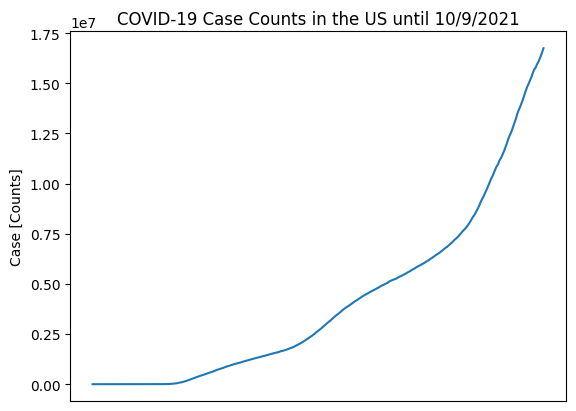

In [18]:
# See cases over the entire dataset, grouped by day
cases = dates_ordered[['date', 'cases']].sum('cases')
frame1 = plt.gca()
plt.plot(cases)
plt.ylabel('Case [Counts]')
frame1.axes.get_xaxis().set_visible(False)
plt.title('COVID-19 Case Counts in the US until 10/9/2021')
plt.savefig(FOLDERNAME+'case_counts', bbox_inches='tight')
# dates_ordered[['date', 'cases']].sum('cases').plot(title='Cases over Time', ylabel='Log Cases')

# Train/Test Split by State (proxy for testing quality) (https://www.nytimes.com/interactive/2020/us/coronavirus-testing.html)

In [26]:
#final_data.head()
state_split_all_data = final_data[['state', 'cases', 'Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500', 'Civilian_labor_force_2020',	'Employed_2020',	'Unemployed_2020',	'Unemployment_rate_2020',	'Median_Household_Income_2020',	'Med_HH_Income_Percent_of_State_Total_2020',	'POVALL_2020',	'POV017_2020']].copy()
#First, we normalize using sklearn's MinMaxScaler()
#x2 = X2.values #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
#state_split_all_data[['Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500']] = min_max_scaler.fit_transform(state_split_all_data[['Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500']])
state_split_all_data_normalized = state_split_all_data.sample(frac=1) #shuffle everything

X2 = state_split_all_data_normalized[['state', 'Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500', 'Civilian_labor_force_2020',	'Employed_2020',	'Unemployed_2020',	'Unemployment_rate_2020',	'Median_Household_Income_2020',	'Med_HH_Income_Percent_of_State_Total_2020',	'POVALL_2020',	'POV017_2020']]
y2 = state_split_all_data_normalized['cases']


In [27]:
X_train2 = X2[X2['state'].isin(['VT', 'ME', 'NY', 'RI', 'MA', 'NH', 'CT', 'HI', 'MI', 'WA', 'MD', 'NJ', 'CA', 'DE', 'VA', 'CO', 'FL', 'IL', 'NC', 'LA', 'NM', 'WV', 'OR', 'SC', 'AK', 'GA', 'OH', 'AR', 'PA', 'MN', 'IN', 'NV', 'NE', 'UT', 'OK', 'KY', 'MS', 'AZ', 'MO', 'TN', 'TX'])]
X_train2 = X_train2.iloc[:, 1:]
y_train2 = y2[X2['state'].isin(['VT', 'ME', 'NY', 'RI', 'MA', 'NH', 'CT', 'HI', 'MI', 'WA', 'MD', 'NJ', 'CA', 'DE', 'VA', 'CO', 'FL', 'IL', 'NC', 'LA', 'NM', 'WV', 'OR', 'SC', 'AK', 'GA', 'OH', 'AR', 'PA', 'MN', 'IN', 'NV', 'NE', 'UT', 'OK', 'KY', 'MS', 'AZ', 'MO', 'TN', 'TX'])]

X_val_test2 = X2[X2['state'].isin(['SD', 'IA', 'WY', 'ID', 'KS', 'AL', 'MT', 'WI'])]
X_val_test2 = X_val_test2.iloc[:, 1:]
y_val_test2 = y2[X2['state'].isin(['SD', 'IA', 'WY', 'ID', 'KS', 'AL', 'MT', 'WI'])]

X_val_states, X_test_states, y_val_states, y_test_states = train_test_split(X_val_test2, y_val_test2, test_size=0.50, random_state=1)
X_train2.head()

,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020,Median_Household_Income_2020,Med_HH_Income_Percent_of_State_Total_2020,POVALL_2020,POV017_2020
280654,-0.281559,-0.299816,-0.347939,-0.350354,-0.344615,-0.310845,-0.300665,-0.446028,-0.403245,-0.231234,-0.090523,-0.083092,-0.157968,-0.817968,0.979541,0.647018,-0.206238,-0.232837
3941691,-0.333837,-0.379835,-0.393570,-0.392503,-0.373421,-0.390431,-0.484486,-0.447910,-0.398197,-0.228690,-0.356231,-0.360573,-0.298618,-1.479420,-0.147148,-0.337719,-0.337279,-0.312020
1992637,-0.288152,-0.352311,-0.306194,-0.346271,-0.320722,-0.291490,-0.498495,-0.422880,-0.351329,-0.214279,-0.225138,-0.226119,-0.205687,-0.203762,-1.095580,-1.032932,-0.060498,-0.061311
1013762,-0.326385,-0.331984,-0.337792,-0.350400,-0.308929,-0.393848,-0.433352,-0.448286,-0.350608,-0.238863,-0.313527,-0.317238,-0.263881,-0.203762,-1.025820,-0.823457,-0.255088,-0.248228
3230262,-0.252517,-0.291266,-0.290412,-0.259833,-0.239582,-0.220185,-0.225115,-0.247670,-0.249660,-0.234624,-0.156006,-0.154810,-0.160564,-0.203762,0.130554,0.861830,-0.134329,-0.118522


In [28]:
print("Train Set Dimensions : ", X_train2.shape)
print("Train Labels Dimensions : ", y_train2.shape)
print("Val Set Dimensions : ", X_val_states.shape)
print("Val Labels Dimensions : ", y_val_states.shape)
print("Test Set Dimensions : ", X_test_states.shape)
print("Test Labels Dimensions : ", y_test_states.shape)

Train Set Dimensions :  (3271546, 18)
Train Labels Dimensions :  (3271546,)
Val Set Dimensions :  (344840, 18)
Val Labels Dimensions :  (344840,)
Test Set Dimensions :  (344840, 18)
Test Labels Dimensions :  (344840,)


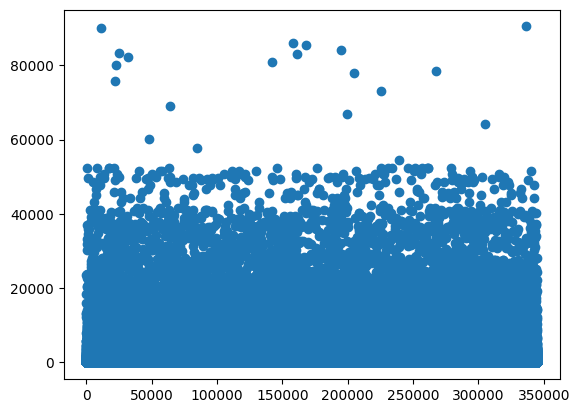

In [29]:
plt.scatter(range(X_test_states.shape[0]), y_test_states)

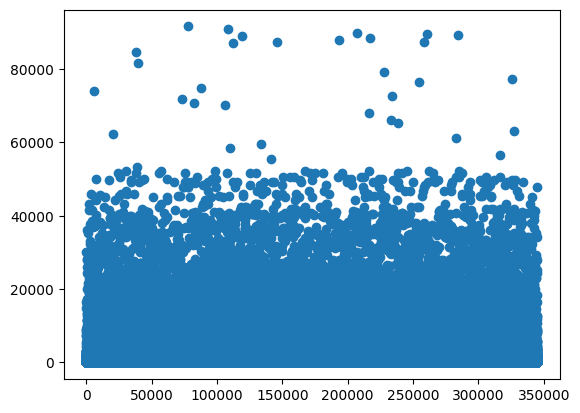

In [30]:
plt.scatter(range(X_val_states.shape[0]), y_val_states)

# **4. MODELING** 

##2 Layer Neural Network (Tensorflow)

In [31]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [32]:
normalizer.adapt(np.array(X_train2)) #removed states for now bc not in number format

In [33]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(False)

In [34]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

In [35]:
dnn_model1 = build_and_compile_model(normalizer)
dnn_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 18)               37        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                1216      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,478
Trainable params: 5,441
Non-trainable params: 37
_________________________________________________________________


In [ ]:
%%time
history = dnn_model1.fit(
    X_train2,
    y_train2,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
81789/81789 [==============================] - 342s 4ms/step - loss: 1144.6071 - val_loss: 1135.1610
Epoch 2/100
81789/81789 [==============================] - 329s 4ms/step - loss: 1084.2920 - val_loss: 1057.0012
Epoch 3/100
81789/81789 [==============================] - 328s 4ms/step - loss: 1058.1282 - val_loss: 1040.3829
Epoch 4/100
81789/81789 [==============================] - 329s 4ms/step - loss: 1037.7046 - val_loss: 1030.3175
Epoch 5/100
81789/81789 [==============================] - 328s 4ms/step - loss: 1022.7799 - val_loss: 1007.3969
Epoch 6/100
81789/81789 [==============================] - 329s 4ms/step - loss: 1009.0737 - val_loss: 1014.8389
Epoch 7/100
81789/81789 [==============================] - 331s 4ms/step - loss: 999.0567 - val_loss: 995.8398
Epoch 8/100
81789/81789 [==============================] - 333s 4ms/step - loss: 989.4095 - val_loss: 989.8885
Epoch 9/100
81789/81789 [==============================] - 327s 4ms/step - loss: 982.4712 - val_loss

In [37]:
plot_loss(history)

NameError: ignored

In [ ]:
test_results = dnn_model1.evaluate(X_val_states.iloc[:, 1:], y_val_states, verbose=0)

In [ ]:
test_results

In [ ]:
val_predictions_nnmodel1 = dnn_model1.predict(X_val_states.iloc[:, 1:]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_val_states, val_predictions_nnmodel1)
plt.title('2L-NN')
plt.xlabel('True Values [Case Counts]')
plt.ylabel('Predictions [Case Counts]')
plt.show()

In [ ]:
corr_nn2, _ = pearsonr(y_val_states, val_predictions_nnmodel1)
print("Pearson Correlation Coefficient = ", corr_nn2) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_val_states, val_predictions_nnmodel1))


In [ ]:
error = val_predictions_nnmodel1 - y_val_states
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Case Counts]')
_ = plt.ylabel('Count')

In [ ]:
dnn_model1.save('dnn_model1')

## 3 Layer NN (Tensorflow)

In [ ]:
def build_and_compile_model2(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

In [ ]:
dnn_model2 = build_and_compile_model2(normalizer)
dnn_model2.summary()

In [ ]:
%%time
history2 = dnn_model2.fit(
    Xtrain2_tf,
    y_train2,
    validation_split=0.2,
    verbose=1, epochs=100)

In [ ]:
plot_loss(history2)

In [ ]:
val_predictions_nnmodel2 = dnn_model2.predict(X_val_states.iloc[:, 1:]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_val_states, val_predictions_nnmodel2)
plt.title('3L-NN')
plt.xlabel('True Values [Case Counts]')
plt.ylabel('Predictions [Case Counts]')
plt.show()

In [ ]:
corr_nn3, _ = pearsonr(y_val_states, val_predictions_nnmodel2)
print("Pearson Correlation Coefficient = ", corr_nn3) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_val_states, val_predictions_nnmodel2))

In [ ]:
dnn_model2.save('dnn_model2')

In [ ]:
error = val_predictions_nnmodel2 - y_val_states
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Case Counts]')
_ = plt.ylabel('Count')

## 10 Layer NN (Tensorflow)

In [ ]:
def build_and_compile_model3(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

In [ ]:
dnn_model3 = build_and_compile_model3(normalizer)
dnn_model3.summary()

In [ ]:
%%time
history3 = dnn_model3.fit(
    Xtrain2_tf,
    y_train2,
    validation_split=0.2,
    verbose=1, epochs=100)

In [ ]:
plot_loss(history3)

In [ ]:
val_predictions_nnmodel3 = dnn_model3.predict(X_val_states.iloc[:, 1:]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_val_states, val_predictions_nnmodel3)
plt.title('10L-NN')
plt.xlabel('True Values [Case Counts]')
plt.ylabel('Predictions [Case Counts]')
plt.show()

In [ ]:
corr_nn10, _ = pearsonr(y_val_states, val_predictions_nnmodel3)
print("Pearson Correlation Coefficient = ", corr_nn10) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_val_states, val_predictions_nnmodel3))

In [ ]:
dnn_model3.save('dnn_model3')

In [ ]:
error = val_predictions_nnmodel3 - y_val_states
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Case Counts]')
_ = plt.ylabel('Count')

## Test NN in TF

In [ ]:
def build_and_compile_model4(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

dnn_model4 = build_and_compile_model4(normalizer)
dnn_model4.summary()

In [ ]:
%%time
history4 = dnn_model4.fit(
    Xtrain2_tf,
    y_train2,
    validation_split=0.2,
    verbose=1, epochs=100)

In [ ]:
plot_loss(history4)

In [ ]:
val_predictions_nnmodel4 = dnn_model4.predict(X_val_states.iloc[:, 1:]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_val_states, val_predictions_nnmodel3)
plt.title('4L-NN')
plt.xlabel('True Values [Case Counts]')
plt.ylabel('Predictions [Case Counts]')
plt.show()

In [ ]:
corr_nnCustom, _ = pearsonr(y_val_states, val_predictions_nnmodel4)
print("Pearson Correlation Coefficient = ", corr_nnCustom) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_val_states, val_predictions_nnmodel4))

In [ ]:
dnn_model4.save('dnn_model4')

In [ ]:
error = val_predictions_nnmodel4 - y_val_states
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Case Counts]')
_ = plt.ylabel('Count')

## 7 Layer NN with Varying Width (32 - 64 - 128 - 64 - 32 - 16 - 1)

In [ ]:
def build_and_compile_model5(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

dnn_model5 = build_and_compile_model5(normalizer)
dnn_model5.summary()

In [ ]:
%%time
history5 = dnn_model5.fit(
    Xtrain2_tf,
    y_train2,
    validation_split=0.2,
    verbose=1, epochs=100)

In [ ]:
plot_loss(history5)

In [ ]:
val_predictions_nnmodel5 = dnn_model5.predict(X_val_states.iloc[:, 1:]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_val_states, val_predictions_nnmodel5)
plt.title('7L-Expansion Contraction FCNN')
plt.xlabel('True Values [Case Counts]')
plt.ylabel('Predictions [Case Counts]')
plt.show()

In [ ]:
corr_nnCustom, _ = pearsonr(y_val_states, val_predictions_nnmodel5)
print("Pearson Correlation Coefficient = ", corr_nnCustom) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_val_states, val_predictions_nnmodel5))

In [ ]:
dnn_model5.save(FOLDERNAME+'/modelFCNN7Layers')

In [ ]:
error = val_predictions_nnmodel5 - y_val_states
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Case Counts]')
_ = plt.ylabel('Count')

## 4 Layer NN with Varying Width (16 - 32 - 16 - 1)

In [ ]:
def build_and_compile_model8(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(16, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

dnn_model8 = build_and_compile_model8(normalizer)
dnn_model8.summary()

In [ ]:
%%time
history8 = dnn_model8.fit(
    Xtrain2_tf,
    y_train2,
    validation_split=0.2,
    verbose=1, epochs=100)

In [ ]:
plot_loss(history8)

In [ ]:
val_predictions_nnmodel8 = dnn_model8.predict(X_val_states.iloc[:, 1:]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_val_states, val_predictions_nnmodel8)
plt.title('4L-Expansion Contraction FCNN')
plt.xlabel('True Values [Case Counts]')
plt.ylabel('Predictions [Case Counts]')
plt.show()

In [ ]:
corr_nnCustom, _ = pearsonr(y_val_states, val_predictions_nnmodel8)
print("Pearson Correlation Coefficient = ", corr_nnCustom) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_val_states, val_predictions_nnmodel8))

In [ ]:
dnn_model8.save(FOLDERNAME+'/modelFCNN4Layers')

In [ ]:
error = val_predictions_nnmodel8 - y_val_states
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Case Counts]')
_ = plt.ylabel('Count')

## 3 Layer NN (width = 16, Tensorflow)

In [ ]:
def build_and_compile_model6(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(16, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

dnn_model6 = build_and_compile_model6(normalizer)
dnn_model6.summary()

In [ ]:
%%time
history6 = dnn_model6.fit(
    Xtrain2_tf,
    y_train2,
    validation_split=0.2,
    verbose=1, epochs=100)

In [ ]:
plot_loss(history6)

In [ ]:
val_predictions_nnmodel6 = dnn_model6.predict(X_val_states.iloc[:, 1:]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_val_states, val_predictions_nnmodel6)
plt.title('3L-NN')
plt.xlabel('True Values [Case Counts]')
plt.ylabel('Predictions [Case Counts]')
plt.show()

In [ ]:
corr_nnCustom, _ = pearsonr(y_val_states, val_predictions_nnmodel6)
print("Pearson Correlation Coefficient = ", corr_nnCustom) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_val_states, val_predictions_nnmodel6))

In [ ]:
dnn_model6.save('dnn_model6')

In [ ]:
error = val_predictions_nnmodel6 - y_val_states
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Case Counts]')
_ = plt.ylabel('Count')

## 3 Layer NN (width = 9, Tensorflow)

In [ ]:
def build_and_compile_model7(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(9, activation='relu'),
      layers.Dense(9, activation='relu'),
      layers.Dense(9, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

dnn_model7 = build_and_compile_model7(normalizer)
dnn_model7.summary()

In [ ]:
%%time
history7 = dnn_model7.fit(
    Xtrain2_tf,
    y_train2,
    validation_split=0.2,
    verbose=1, epochs=100)

In [ ]:
plot_loss(history7)

In [ ]:
val_predictions_nnmodel7 = dnn_model7.predict(X_val_states.iloc[:, 1:]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_val_states, val_predictions_nnmodel7)
plt.title('3L-NN')
plt.xlabel('True Values [Case Counts]')
plt.ylabel('Predictions [Case Counts]')
plt.show()

In [ ]:
corr_nnCustom, _ = pearsonr(y_val_states, val_predictions_nnmodel7)
print("Pearson Correlation Coefficient = ", corr_nnCustom) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_val_states, val_predictions_nnmodel7))

In [ ]:
dnn_model7.save('dnn_model7')

In [ ]:
error = val_predictions_nnmodel7 - y_val_states
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Case Counts]')
_ = plt.ylabel('Count')

## 2 Layer NN (width = 16, Tensorflow)

In [ ]:
def build_and_compile_model9(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(16, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

dnn_model9 = build_and_compile_model9(normalizer)
dnn_model9.summary()

In [ ]:
%%time
history9 = dnn_model9.fit(
    Xtrain2,
    y_train2,
    validation_split=0.2,
    verbose=1, epochs=100)

In [ ]:
plot_loss(history9)

In [ ]:
val_predictions_nnmodel9 = dnn_model9.predict(X_val_states).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_val_states, val_predictions_nnmodel9)
plt.title('2L-FCNN (HU=16)')
plt.xlabel('True Values [Case Counts]')
plt.ylabel('Predictions [Case Counts]')
plt.show()

In [ ]:
corr_nnCustom, _ = pearsonr(y_val_states, val_predictions_nnmodel9)
print("Pearson Correlation Coefficient = ", corr_nnCustom) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_val_states, val_predictions_nnmodel9))

In [ ]:
dnn_model9.save(FOLDERNAME+'/dnn_model9')

In [ ]:
error = val_predictions_nnmodel9 - y_val_states
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Case Counts]')
_ = plt.ylabel('Count')

# **5. METRICS** 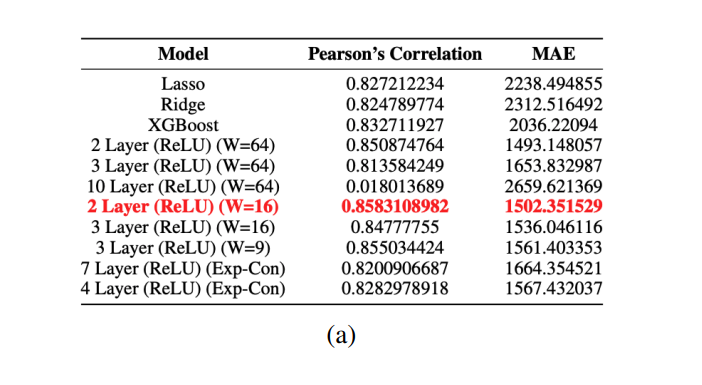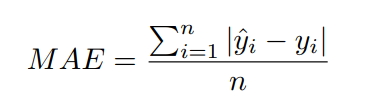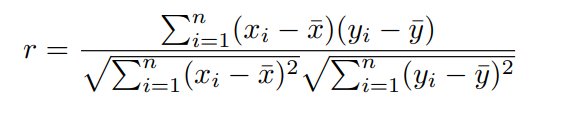

## Test Set Performance

In [ ]:
X_test_states

In [ ]:
new_model = tf.keras.models.load_model(FOLDERNAME+'/dnn_model9')

test_predictions = new_model.predict(X_test_states.iloc[:, 1:]).flatten()

In [ ]:
print('Test Min = ', test_predictions.min())
print('Test Max = ', test_predictions.max())

In [ ]:
new_model.summary()

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(y_test_states, test_predictions)
plt.title('2L-FCNN (HU=16) Test Set')
plt.xlabel('True Values [Case Counts]')
plt.ylabel('Predictions [Case Counts]')
plt.show()

In [ ]:
corr_nnCustom, _ = pearsonr(y_test_states, test_predictions)
print("Pearson Correlation Coefficient = ", corr_nnCustom) # Note: r = 0.5 - 1.0 means strong positive association
print("Mean Abolsute Error = ", mean_absolute_error(y_test_states, test_predictions))

# **5. REFERENCES** 

- US Department of Transportation. https://data.bts.gov/Research-and-Statistics/Trips-by-Distance/w96p-f2qv
- New York Times https://github.com/nytimes/covid-19-data
- “Usda ers.” [Online]. Available: https://www.ers.usda.gov/data-products/county-level-data-sets/
download-data